### Load the Packages

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [4]:
# Use graphviz to make a chart of the regression tree decision points:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus


### Fetch and Read the Data into a DataFrame

In [5]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfm.csv',
                   encoding='utf8')

In [6]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,reviews,reviews_count,room_type
0,0,1.0,0.0,1.0,0.251722,8989,13,3.0,Municipio 1,2.0,167.0,77,0,140078,Entire home/apt
1,1,1.0,1.0,1.0,0.251722,8989,13,3.0,Municipio 1,4.5,121.0,77,20,140078,Entire home/apt


In [7]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [8]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)



In [9]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + reviews + reviews_count + room_type -1'

### Using Patsy for Categorical Variables

In [10]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

### Standardizing the Data

In [11]:
Xn = StandardScaler().fit_transform(X)

### Splitting the Data into Train and Test

In [12]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

### Random Forest Regression with GridSearch

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


### Run Parametric Search to Obtain most Optimized Parameters for the given Dataset

In [14]:
# rf = RandomForestRegressor()

# rf_params = {
#     'n_estimators':[500],
#     'max_depth':[5,8,15,25,30,None],
#     'min_samples_split':[2,4,8,16,32,64,128],
#     'max_features':[None, 'sqrt', 'log2']
# }

# rf_gs = GridSearchCV(rf, rf_params, cv= 10, verbose=1, n_jobs=-1)
# rf_gs.fit(Xn_train, y_train)

In [15]:
# print rf_gs.best_params_
# rf_best = rf_gs.best_estimator_

# rf_scores = cross_val_score(rf_best, Xn_train, y_train, cv=10)
# print rf_scores
# print np.mean(rf_scores), np.std(rf_scores)

#### The parameters entered in the Random Forest Regressor below are obtained from the parametric search above at the given settings

In [16]:
import time

In [17]:
start_time = time.time()

rf = RandomForestRegressor(max_features='sqrt', min_samples_split=32, n_estimators=500, max_depth=15)

y_pred = rf.fit(Xn_train,y_train).predict(Xn_test)
r2_score = metrics.r2_score(y_test, y_pred)
print("r^2 on test data : %f" % r2_score)

print("--- %s seconds ---" % (time.time() - start_time))



r^2 on test data : 0.541084
--- 3.92094016075 seconds ---


In [18]:
#rf.feature_importances_

In [19]:
feature_imp = {}
for i, value in enumerate(rf.feature_importances_):
    feature_imp[i] = value

feature_imp = pd.DataFrame(feature_imp.items(), columns=['item_no','imp'])
feature_imp.head(2)

,item_no,imp
0,0,0.037130
1,1,0.000008


In [21]:
feature_name = {}
for i, value in enumerate(X.columns):
    feature_name[i] = value

feature_name = pd.DataFrame(feature_name.items(), columns=['item_no','name'])
feature_name.head(2)

,item_no,name
0,0,neighborhood[Municipio 1]
1,1,neighborhood[Municipio 10]


In [22]:
feature_val = feature_name.merge(feature_imp, on='item_no')
feature_val.sort_values('imp',inplace=True,ascending=False,axis=0)

In [23]:
feature_val = feature_val.reset_index(drop=True)

In [24]:
feature_val.head(25)

,item_no,name,imp
0,17,bedrooms,0.189168
1,14,room_type[T.Private room],0.179135
2,16,bathrooms,0.140967
3,24,reviews,0.081432
4,21,minstay,0.061169
5,23,rest_count,0.057643
6,19,host_count,0.053763
7,25,reviews_count,0.051472
8,22,overall_satisfaction,0.042231
9,0,neighborhood[Municipio 1],0.037130


### Feature Importance Plot

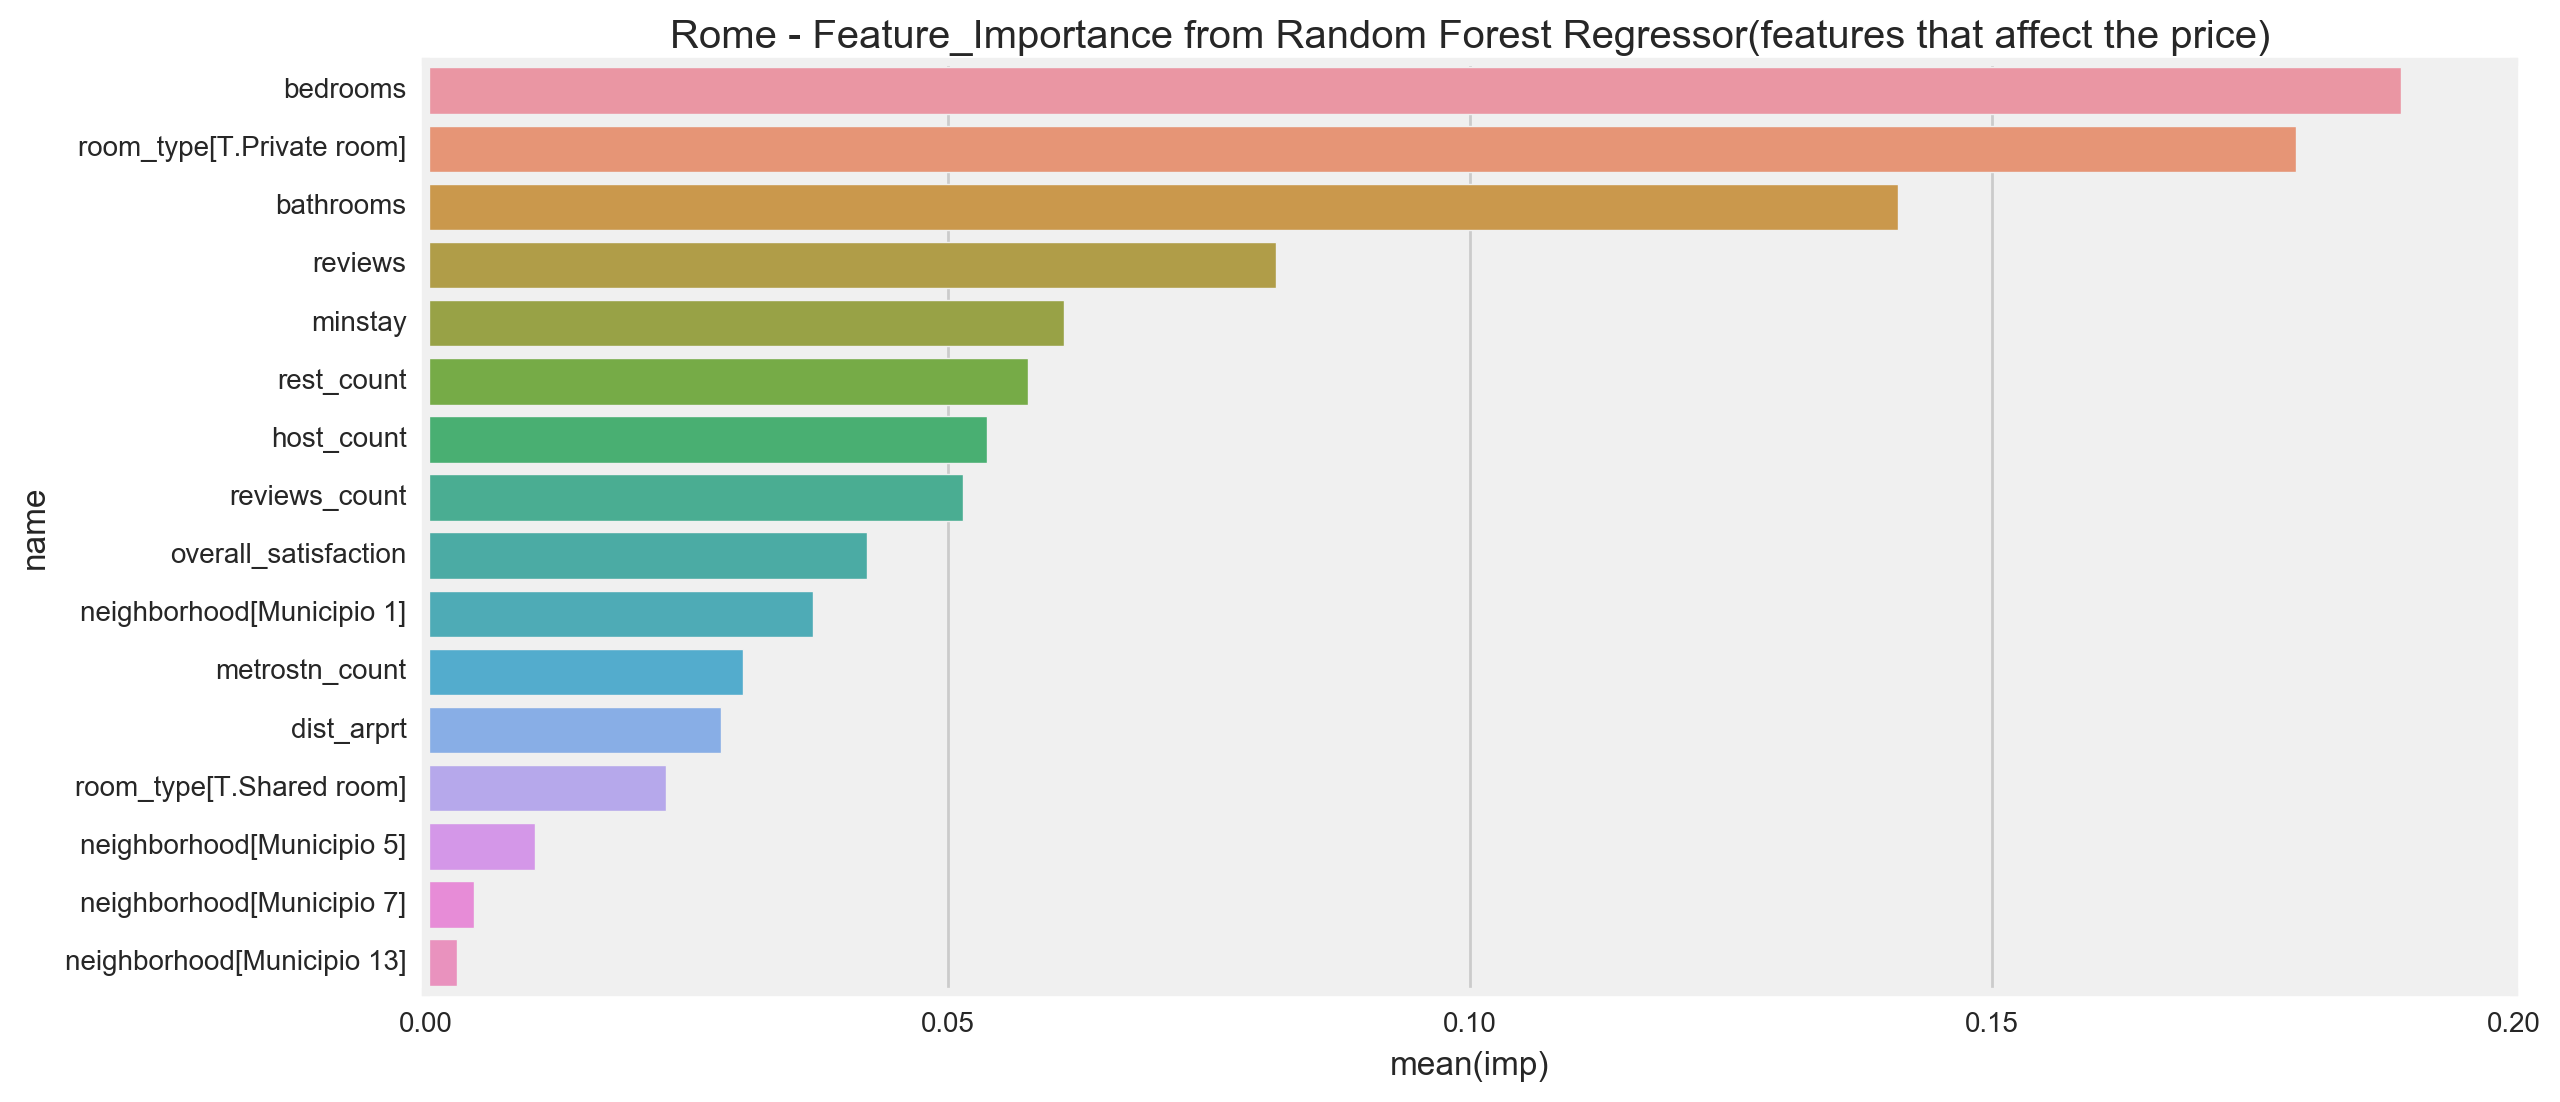

In [26]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = feature_val.loc[0:15,:].name, x = feature_val.loc[0:15,:].imp, data=feature_val.loc[0:15,:],
            orient="", ax=ax
           )

ax.set_title("Rome - Feature_Importance from Random Forest Regressor(features that affect the price)")
plt.show()